## DENISE PRISCILA MUWANGUZI
### M23B23/010
### B20237

# Association Rule Mining for Cassava Yield Data

This notebook performs association rule apriori mining to identify relationships between fertilizers across seasons in the Cassava Yield Data dataset.

#### Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from itertools import combinations
from collections import defaultdict

import networkx as nx
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules


#### Loading the dataset

In [2]:
df = pd.read_excel("Cassava_Yield_Data.xlsx", sheet_name='Cassava Data')
df

/opt/anaconda3/lib/python3.12/site-packages/openpyxl/packaging/core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()
/opt/anaconda3/lib/python3.12/site-packages/openpyxl/packaging/core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()


,Sesn,locn,block,rep,tillage,ferT,Plants_harvested,No_bigtubers,Weigh_bigtubers,No_mediumtubers,Weight_mediumtubers,No_smalltubers,Weight_smalltubers,Totaltuberno,AV_tubers_Plant,Total_tubweight,plotsize,HEC,TotalWeightperhectare,TotalTuberperHectare
0,2,1,1,1,conv,F2150,28,0,0.0,61,2.5,319,4.7,380,13.571429,7.2,5.3,10000,13584.905660,716981.132075
1,2,1,1,1,conv,F1100,28,0,0.0,110,4.6,260,4.0,370,13.214286,8.6,5.3,10000,16226.415094,698113.207547
2,2,1,1,1,conv,F3200,28,2,0.2,115,5.2,319,4.4,436,15.571429,9.8,5.3,10000,18490.566038,822641.509434
3,2,1,1,1,conv,F5300,28,6,0.7,60,2.7,303,4.8,369,13.178571,8.2,5.3,10000,15471.698113,696226.415094
4,2,1,1,1,conv,F4250,28,3,0.3,82,3.4,332,4.7,417,14.892857,8.4,5.3,10000,15849.056604,786792.452830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,2,2,3,3,conv,F1100,19,0,0.0,33,1.0,220,2.1,253,13.315789,3.1,4.2,10000,7380.952381,602380.952381
111,2,2,3,3,conv,F5300,16,0,0.0,22,1.0,204,1.9,226,14.125000,2.9,4.2,10000,6904.761905,538095.238095
112,2,2,3,3,conv,F2150,13,0,0.0,8,0.4,52,1.2,60,4.615385,1.6,4.2,10000,3809.523810,142857.142857
113,2,2,3,3,conv,F4250,20,0,0.0,42,1.9,91,1.8,133,6.650000,3.7,4.2,10000,8809.523810,316666.666667


In [3]:
# Display column names to confirm structure
print(df.columns)

Index(['Sesn', 'locn', 'block', 'rep', 'tillage ', 'ferT', 'Plants_harvested',
       'No_bigtubers', 'Weigh_bigtubers', 'No_mediumtubers',
       'Weight_mediumtubers', 'No_smalltubers', 'Weight_smalltubers',
       'Totaltuberno', 'AV_tubers_Plant', 'Total_tubweight', 'plotsize', 'HEC',
       'TotalWeightperhectare', 'TotalTuberperHectare'],
      dtype='object')


In [4]:
df.shape

(115, 20)

In [5]:
df.dtypes

Sesn                       int64
locn                       int64
block                      int64
rep                        int64
tillage                   object
ferT                      object
Plants_harvested           int64
No_bigtubers               int64
Weigh_bigtubers          float64
No_mediumtubers            int64
Weight_mediumtubers      float64
No_smalltubers             int64
Weight_smalltubers       float64
Totaltuberno               int64
AV_tubers_Plant          float64
Total_tubweight          float64
plotsize                 float64
HEC                        int64
TotalWeightperhectare    float64
TotalTuberperHectare     float64
dtype: object

In [6]:
df.isnull().sum()

Sesn                     0
locn                     0
block                    0
rep                      0
tillage                  0
ferT                     0
Plants_harvested         0
No_bigtubers             0
Weigh_bigtubers          0
No_mediumtubers          0
Weight_mediumtubers      0
No_smalltubers           0
Weight_smalltubers       0
Totaltuberno             0
AV_tubers_Plant          0
Total_tubweight          0
plotsize                 0
HEC                      0
TotalWeightperhectare    0
TotalTuberperHectare     0
dtype: int64

In [7]:
# Group fertilizers by season
season_groups = df.groupby("Sesn")["ferT"].apply(list).tolist()

In [8]:
#  Convert to Transaction Format 
te = TransactionEncoder()
te_array = te.fit(season_groups).transform(season_groups)
transactions = pd.DataFrame(te_array, columns=te.columns_)

In [9]:
# --- Step 6: Apply Apriori ---
frequent_itemsets = apriori(transactions, min_support=0.2, use_colnames=True)

In [10]:
# --- Step 7: Association Rules ---
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

/opt/anaconda3/lib/python3.12/site-packages/mlxtend/frequent_patterns/association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


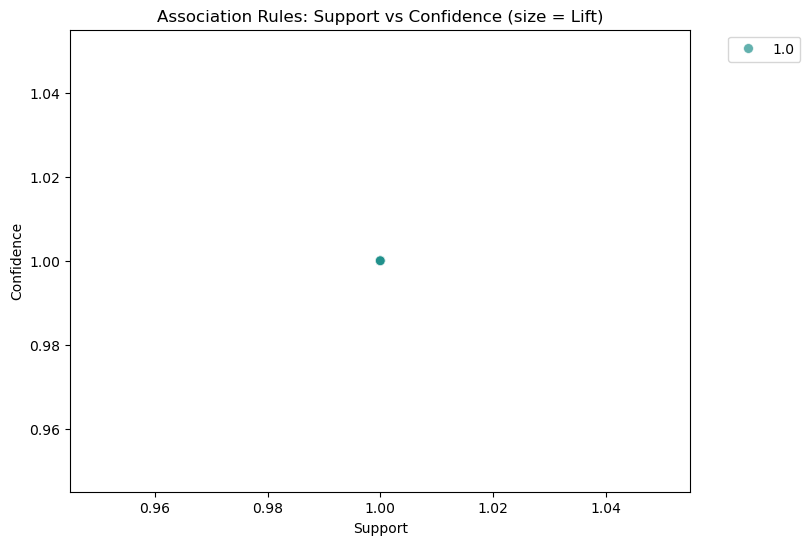

In [11]:
# --- Step 8: Visualization 1 - Scatter Plot (Support vs Confidence vs Lift) ---
plt.figure(figsize=(8,6))
sns.scatterplot(data=rules, x="support", y="confidence", size="lift", 
                sizes=(50, 500), hue="lift", alpha=0.7, palette="viridis")
plt.title("Association Rules: Support vs Confidence (size = Lift)")
plt.xlabel("Support")
plt.ylabel("Confidence")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

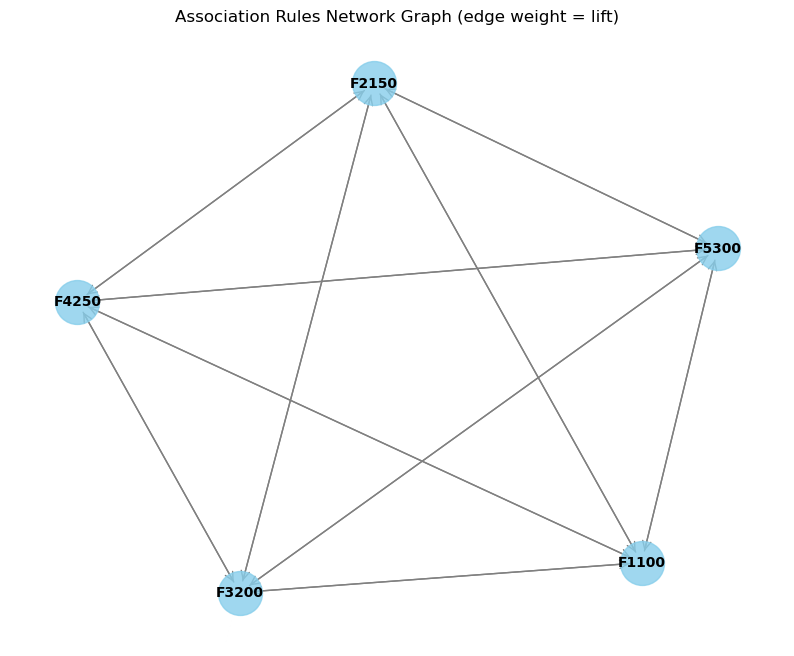

In [13]:
# --- Step 9: Visualization 2 - Network Graph of Rules ---
# Build a directed graph
G = nx.DiGraph()

for _, row in rules.iterrows():
    # Each rule is (antecedent -> consequent)
    for antecedent in row['antecedents']:
        for consequent in row['consequents']:
            G.add_edge(antecedent, consequent, weight=row['lift'])

plt.figure(figsize=(10,8))
pos = nx.spring_layout(G, k=0.5, seed=42)
edges = G.edges(data=True)

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=1000, node_color="skyblue", alpha=0.8)
# Draw edges with thickness based on lift
nx.draw_networkx_edges(G, pos, arrowstyle="->", arrowsize=15,
                       edge_color="gray", width=[d['weight'] for (u,v,d) in edges])
# Draw labels
nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")

plt.title("Association Rules Network Graph (edge weight = lift)")
plt.axis("off")
plt.show()
